In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

df_training = pd.read_csv('/home/jose/data_science_test/Datasets/training_set.csv')#
df_training.head()

,ActiveDays,AGE_h4,Billed_Lifetime,C_Trust,churn,D_ActiveDays,D_ARPU,D_InVoice_Velcom_Dur,D_OutVoice_FNF_Dur,D_OutVoice_Velcom_Dur,...,S_BARBL,shock_data_b,shock_int_b,shock_ISR_b,shock_roam_b,shock_vas_b,Total_Fee,X2G_VOICE_Usage_Sum_Sum,X3G_Data_Usage_Sum_Sum,X3G_VOICE_Usage_Sum_Sum
0,22.333333,48,81.733333,0,1,0.358209,0.490435,0.511229,0.0,0.401664,...,0,0,0,0,0,0,12.90944,91.22,14820.724066,986.60
1,8.666667,84,NaN,7,1,0.115385,0.800254,0.000000,0.0,0.000000,...,1,0,0,0,0,0,8.06400,317.62,0.000000,0.00
2,17.333333,44,81.700000,7,1,0.403846,0.785503,0.229036,0.0,0.000000,...,1,0,0,0,0,0,4.75976,46.44,0.000000,0.00
3,29.666667,35,170.266667,9,1,1.044944,0.344440,0.485012,0.0,0.166236,...,0,0,0,0,0,0,9.85392,83.92,5929.615768,1662.22
4,0.000000,62,NaN,9,1,0.000000,0.000000,0.000000,0.0,0.000000,...,2,0,0,0,0,0,2.09484,0.00,0.000000,0.00


In [2]:
df_training[['D_R_OutVoice_TOP5_Comp', 'D_Req_Barring_Cnt', 'Req_Barring_LM_Cnt', 'R_OutVoice_TOP5_Comp', 'R_InVoice_TOP5_Comp', 'R_OutVoice_BCL_Dur']].agg([np.min, np.max, np.std])

,D_R_OutVoice_TOP5_Comp,D_Req_Barring_Cnt,Req_Barring_LM_Cnt,R_OutVoice_TOP5_Comp,R_InVoice_TOP5_Comp,R_OutVoice_BCL_Dur
amin,0.0,0.0,0.0,0.0,0.0,0.0
amax,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Заполняю пропуски средним по группе
mean_r = lambda x: x.fillna(x.mean())

df_training[['ActiveDays']] = df_training[['ActiveDays', 'churn']].groupby('churn').transform(mean_r)
df_training[['Billed_Lifetime']] = df_training[['Billed_Lifetime', 'churn']].groupby('churn').transform(mean_r)

# Среднее по этому признаку почти 0.0, но возможно его можно рассматривать как категориальный?
df_training[['D_S_BARBL']] = df_training[['D_S_BARBL']].fillna(0.0)

# Эти признаки все = 0 
df_training.drop(['D_R_OutVoice_TOP5_Comp', 'D_Req_Barring_Cnt', 'Req_Barring_LM_Cnt', 'R_OutVoice_TOP5_Comp', 'R_InVoice_TOP5_Comp', 'R_OutVoice_BCL_Dur'],axis=1,inplace=True)

In [4]:
# Обрабатываю категориальные признаки

dfg = df_training[['C_Trust', 'churn']]

#for i in dfg['C_Trust'].value_counts(sort=False).index:
#    print(i)

y_mean = dfg['churn'].mean()
tau = dfg['churn'].var()

df_stat = dfg.groupby('C_Trust').agg([np.mean, np.var, np.sum, np.size])

def trans_category(x):   
      
    n = x.count()
    y = x.mean()
    sigma = x.var()
    if (pd.notna(sigma)):
        B = n*tau/(sigma + n*tau)
    else: 
        B = 0.
        
    S = B*y + (1-B)*y_mean
    
    return S

dfg_modified = dfg.groupby('C_Trust').transform(lambda x: trans_category(x)) 

dfg['churn'] = dfg_modified

c_trust_dict = dfg.set_index('C_Trust')['churn'].to_dict()
c_trust_dict

#df_training['C_Trust'] = dfg_modified

# -------------
#print(dfg['C_Trust'].value_counts(sort=False))
#df_stat = dfg.sort_values('C_Trust')
#.agg([np.mean, np.var, np.sum, np.size])
#df_stat
#for i in range(dfg['C_Trust'].size):
#    dfg['C_Trust'][i] = dfg['C_Trust'][i]

{0: 0.1418063375584305,
 1: 0.13758480591627253,
 2: 0.14351953637903164,
 3: 0.14359264330842408,
 4: 0.1476902039517532,
 5: 0.142316552165713,
 6: 0.1377055128612181,
 7: 0.1387085176388505,
 8: 0.13858060348334,
 9: 0.14339477153482202}

In [6]:
dfg = df_training[['ReferDisconnect_Cnt', 'churn']]
df_stat = dfg.groupby('ReferDisconnect_Cnt').agg([np.mean, np.var, np.sum, np.size])
#print(df_stat)
dfg_modified = dfg.groupby('ReferDisconnect_Cnt').transform(lambda x: trans_category(x)) 
#dfg_modified['ReferDisconnect_Cnt'] = dfg['ReferDisconnect_Cnt']
#dfg_modified.groupby('ReferDisconnect_Cnt').isnull()
df_training['ReferDisconnect_Cnt'] = dfg_modified

In [7]:
dfg = df_training[['S_BARBL', 'churn']]
df_stat = dfg.groupby('S_BARBL').agg([np.mean, np.var, np.sum, np.size])
#print(df_stat)
dfg_modified = dfg.groupby('S_BARBL').transform(lambda x: trans_category(x)) 
#dfg_modified['S_BARBL'] = dfg['S_BARBL']
#dfg_modified.groupby('S_BARBL').agg([np.min, np.mean, np.max, np.var, np.sum, np.size])
df_training['S_BARBL'] = dfg_modified

In [8]:
'''Нужно брать zscore по группе или по всей выборке???'''

bin_feat = ['End_TA','HandsetChange_Flag','Multi_SIM_2G_traff_only','Multi_Sub_Max','multiSIM','PP_Change_Max_Max','ReferConsult_Flag','Req_Services_Flag','shock_ISR_b','shock_data_b','shock_int_b','shock_roam_b','shock_vas_b']
num_feat = list(set(df_training.columns) - set(bin_feat) - set(['C_Trust', 'S_BARBL', 'ReferDisconnect_Cnt']) - set(['churn']))
print(num_feat)
zscore = lambda x: (x-x.mean())/x.std()
df_training[num_feat] = df_training[num_feat].transform(zscore)

#df_training[num_feat] = df_training[num_feat].groupby('churn').transform(zscore, inplace=True)


df_training.head()

['OutVoice_Competitor2_Cnt', 'D_InVoice_Velcom_Dur', 'OutVoice_Int_Cnt', 'X2G_VOICE_Usage_Sum_Sum', 'PAYMENTS_AMOUNT', 'OutVoice_Competitor1_Cnt', 'D_ActiveDays', 'R_InVoice_IntEurope_Dur', 'PAYMENTS_QUANTITY', 'D_OutVoice_Velcom_Dur', 'InVoice_IntOther_Dur', 'OutSMS_Cnt', 'OutVoice_CntM', 'ActiveDays', 'In_Velcom_Uniq', 'R_OutSMS_Competitor2_Cnt', 'R_OutVoice_FNF_Dur', 'D_OutVoice_FNF_Dur', 'Billed_Lifetime', 'R_OutSMS_Competitor1_Cnt', 'D_PAYMENTS_AMOUNT', 'X3G_Data_Usage_Sum_Sum', 'X3G_VOICE_Usage_Sum_Sum', 'OutVoice_Other_Dur', 'OutVoiceAvg_Comp_Dur', 'R_OutVoice_Cost', 'D_S_BARBL', 'D_ARPU', 'Offnet_Usage_Sum_Sum', 'Total_Fee', 'AGE_h4', 'R_InVoice_Velcom_Dur', 'R_InVoice_Dur', 'Lifetime_Months', 'InSMS_Cnt']


,ActiveDays,AGE_h4,Billed_Lifetime,C_Trust,churn,D_ActiveDays,D_ARPU,D_InVoice_Velcom_Dur,D_OutVoice_FNF_Dur,D_OutVoice_Velcom_Dur,...,S_BARBL,shock_data_b,shock_int_b,shock_ISR_b,shock_roam_b,shock_vas_b,Total_Fee,X2G_VOICE_Usage_Sum_Sum,X3G_Data_Usage_Sum_Sum,X3G_VOICE_Usage_Sum_Sum
0,-0.148665,0.234908,-0.036884,0,1,-1.662900,-1.289616,-0.866164,-0.846428,-1.044560,...,0.128117,0,0,0,0,0,0.744667,-0.342164,1.275224,0.398849
1,-1.746324,2.533657,-0.662496,7,1,-2.308757,-0.509199,-1.788285,-0.846428,-1.760148,...,0.365410,0,0,0,0,0,-0.017753,-0.019865,-0.183257,-0.565286
2,-0.733174,-0.020508,-0.037510,7,1,-1.541516,-0.546356,-1.375165,-0.846428,-1.760148,...,0.365410,0,0,0,0,0,-0.537668,-0.405913,-0.183257,-0.565286
3,0.708616,-0.595195,1.626301,9,1,0.163660,-1.657370,-0.913452,-0.846428,-1.463989,...,0.128117,0,0,0,0,0,0.263887,-0.352557,0.400266,1.059085
4,-2.759473,1.128866,-0.662496,9,1,-2.615655,-2.524996,-1.788285,-0.846428,-1.760148,...,0.376534,0,0,0,0,0,-0.956987,-0.472024,-0.183257,-0.565286


In [9]:
from sklearn.preprocessing import Normalizer

df_training[num_feat] = Normalizer().fit_transform(df_training[num_feat])

In [10]:
df_training.head()

,ActiveDays,AGE_h4,Billed_Lifetime,C_Trust,churn,D_ActiveDays,D_ARPU,D_InVoice_Velcom_Dur,D_OutVoice_FNF_Dur,D_OutVoice_Velcom_Dur,...,S_BARBL,shock_data_b,shock_int_b,shock_ISR_b,shock_roam_b,shock_vas_b,Total_Fee,X2G_VOICE_Usage_Sum_Sum,X3G_Data_Usage_Sum_Sum,X3G_VOICE_Usage_Sum_Sum
0,-0.026016,0.041108,-0.006455,0,1,-0.291000,-0.225677,-0.151575,-0.148121,-0.182793,...,0.128117,0,0,0,0,0,0.130313,-0.059877,0.223158,0.069797
1,-0.158585,0.230084,-0.060162,7,1,-0.209660,-0.046241,-0.162396,-0.076865,-0.159841,...,0.365410,0,0,0,0,0,-0.001612,-0.001804,-0.016642,-0.051334
2,-0.073143,-0.002046,-0.003742,7,1,-0.153785,-0.054506,-0.137189,-0.084441,-0.175596,...,0.365410,0,0,0,0,0,-0.053639,-0.040495,-0.018282,-0.056394
3,0.154373,-0.129664,0.354293,9,1,0.035654,-0.361061,-0.198997,-0.184396,-0.318933,...,0.128117,0,0,0,0,0,0.057488,-0.076805,0.087199,0.230724
4,-0.314835,0.128795,-0.075586,9,1,-0.298426,-0.288083,-0.204030,-0.096571,-0.200820,...,0.376534,0,0,0,0,0,-0.109185,-0.053854,-0.020908,-0.064495


Text(0.5,1,'Churn distribution')

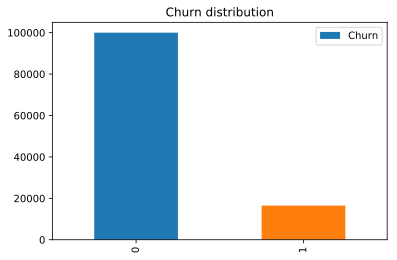

In [11]:
df_training['churn'].value_counts().plot(kind = 'bar', label = 'Churn')
plt.legend()
plt.title('Churn distribution')

In [12]:
df_training.groupby(['churn']).agg([np.mean, np.std])

ActiveDays              AGE_h4           Billed_Lifetime            \
            mean       std      mean       std            mean       std   
churn                                                                      
0       0.047149  0.170896  0.007855  0.212879        0.030516  0.216204   
1      -0.105330  0.197579 -0.030702  0.168934       -0.109588  0.169376   

        C_Trust           D_ActiveDays              ...    shock_vas_b  \
           mean       std         mean       std    ...           mean   
churn                                               ...                  
0      4.499030  2.870843     0.027071  0.125796    ...       0.084770   
1      4.488382  2.864371    -0.081676  0.217344    ...       0.047746   

                Total_Fee           X2G_VOICE_Usage_Sum_Sum            \
            std      mean       std                    mean       std   
churn                                                                   
0      0.278541 -0.001209  0.190957               -0.007028  0.168324   
1      0.213235 -0.040979  0.148818               -0.018161  0.138998   

      X3G_Data_Usage_Sum_Sum           X3G_VOICE_Usage_Sum_Sum            
                        mean       std                    mean       std  
churn                                                                     
0                  -0.010275  0.076607               -0.009516  0.182503  
1                  -0.006803  0.072757               -0.042735  0.124084  

[2 rows x 102 columns]

In [14]:
pd.crosstab(df_training['churn'], df_training['End_TA'], margins = True)

End_TA,0,1,All
churn,,,
0,99254,746,100000
1,16171,312,16483
All,115425,1058,116483


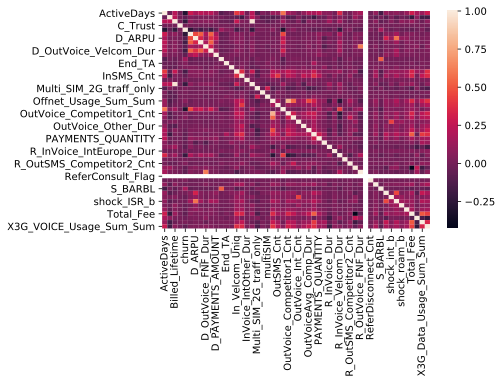

In [15]:
#df_training.corr()
sns.heatmap(df_training.corr())

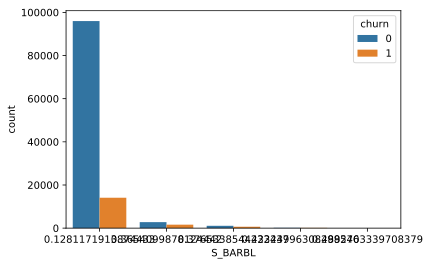

In [16]:
sns.countplot(x='S_BARBL', hue='churn', data=df_training)

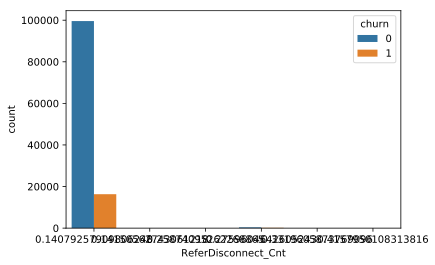

In [17]:
sns.countplot(x='ReferDisconnect_Cnt', hue='churn', data=df_training)

In [102]:
#fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16, 20))

#for idx, feat in  enumerate(imp_feat):
#    sns.boxplot(x='churn', y=feat, data=df_training, ax=axes[idx // 4, idx % 4])
#    axes[idx // 4, idx % 4].set_xlabel('churn')
#    axes[idx // 4, idx % 4].set_ylabel(feat);

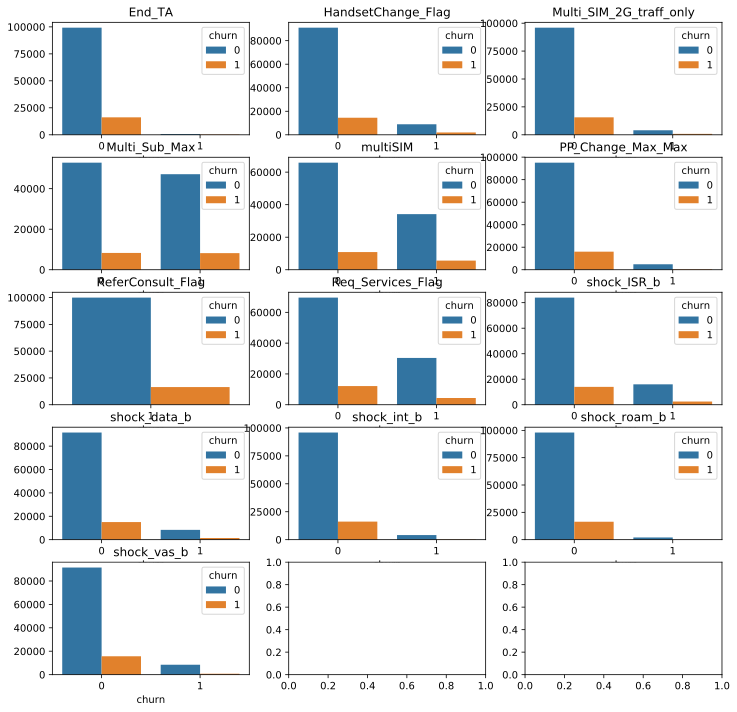

In [18]:
len(bin_feat)
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12,12))

for idx, feat in  enumerate(bin_feat):
    
    sns.countplot(x=feat, hue='churn', data=df_training, ax=axes[idx // 3, idx % 3])
    axes[idx // 3, idx % 3].set_xlabel('churn')
    axes[idx // 3, idx % 3].set_title(feat)
    axes[idx // 3, idx % 3].set_ylabel('')

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

y = df_training[['churn']]
X = df_training.drop('churn', axis = 1)

#X_trans = StandardScaler().fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, shuffle=True)
dict = {'train': X_train, 'valid': X_val}


In [20]:
# Обрабатываю категориальные признаки

dfg = df_training[['C_Trust', 'churn']]

y_mean = dfg['churn'].mean()
tau = dfg['churn'].var()

df_stat = dfg.groupby('C_Trust').agg([np.mean, np.var, np.sum, np.size])

def trans_category(x):
    
    n = x.count()
    y = x.mean()
    sigma = x.var()
    if (pd.notna(sigma)):
        B = n*tau/(sigma + n*tau)
    else: 
        B = 0.
        
    S = B*y + (1-B)*y_mean
    
    return S

dfg_modified = dfg.groupby('C_Trust').transform(lambda x: trans_category(x)) 

df_training['C_Trust'] = dfg_modified


In [21]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

clf_GB = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
#clf_RF = RandomForestClassifier(max_depth=2, random_state=42)
#clf_Log = LogisticRegression(random_state=42)

clf_GB.fit(X_train, y_train)
#clf_RF.fit(X_train, y_train)
#clf_Log.fit(X_train, y_train)

print ('gradient_boosting score = ', clf_GB.score(X_val, y_val))
#print ('random forest score = ', clf_RF.score(X_val, y_val))
#print ('Log score = ', clf_Log.score(X_val, y_val))

gradient_boosting score =  0.8728065657085952


In [ ]:
from sklearn import model_selection

cv_kfold = model_selection.KFold(n_splits = 5, shuffle = True, random_state=17)

gb_param = {'loss':['deviance', 'exponential'], 'n_estimators':np.power(10, np.arange(1, 5))}
gb_param_mini = {'loss':['deviance', 'exponential'], 'n_estimators':[1000, 5000, 10000]}
rf_param = rf_param = {'n_estimators':np.power(10,np.arange(2,5))}
log_param = {'penalty':['l1', 'l2'], 'C':np.power(10.0, np.arange(-1, 3))}

gs_gb = model_selection.GridSearchCV(GradientBoostingClassifier(), gb_param_mini, scoring='accuracy', cv=cv_kfold)
gs_gb.fit(X, y)
gs_rf = model_selection.GridSearchCV(RandomForestClassifier(random_state=42), rf_param, scoring='accuracy', cv=cv_kfold)
gs_rf.fit(X, y)
gs_log = model_selection.GridSearchCV(LogisticRegression(random_state=42), log_param, scoring='accuracy', cv=cv_kfold)
gs_log.fit(X, y)

#print('GB best params = ', gs_gb.best_params_, ' GB best score = ', gs_gb.best_score_)
#print('RF best params = ', gs_rf.best_params_, ' RF best score = ', gs_rf.best_score_)
#print('Log best params = ', gs_log.best_params_, ' Log best score = ', gs_log.best_score_)

In [34]:
clf_GB.feature_importances_

array([0.06, 0.03, 0.03, 0.  , 0.13, 0.02, 0.02, 0.01, 0.03, 0.03, 0.05,
       0.01, 0.01, 0.02, 0.01, 0.  , 0.07, 0.01, 0.01, 0.01, 0.06, 0.  ,
       0.01, 0.  , 0.04, 0.01, 0.01, 0.  , 0.06, 0.03, 0.01, 0.06, 0.  ,
       0.02, 0.  , 0.02, 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.01, 0.  ,
       0.  , 0.  , 0.  , 0.03, 0.01, 0.04, 0.  ])

In [22]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(8, activation='relu', input_shape=(51,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['accuracy'])

Using TensorFlow backend.


In [23]:
history = model.fit(X_train, y_train, epochs=20,  validation_data=(X_val, y_val))

Train on 87362 samples, validate on 29121 samples
Epoch 1/20
87362/87362 [==============================] - 3s 34us/step - loss: 0.3373 - acc: 0.8592 - val_loss: 0.3254 - val_acc: 0.8600
Epoch 2/20
87362/87362 [==============================] - 3s 30us/step - loss: 0.3227 - acc: 0.8642 - val_loss: 0.3255 - val_acc: 0.8651
Epoch 3/20
87362/87362 [==============================] - 3s 31us/step - loss: 0.3212 - acc: 0.8668 - val_loss: 0.3251 - val_acc: 0.8661
Epoch 4/20
87362/87362 [==============================] - 2s 29us/step - loss: 0.3195 - acc: 0.8677 - val_loss: 0.3232 - val_acc: 0.8676
Epoch 5/20
87362/87362 [==============================] - 3s 29us/step - loss: 0.3185 - acc: 0.8685 - val_loss: 0.3206 - val_acc: 0.8693
Epoch 6/20
87362/87362 [==============================] - 3s 30us/step - loss: 0.3174 - acc: 0.8699 - val_loss: 0.3194 - val_acc: 0.8701
Epoch 7/20
87362/87362 [==============================] - 3s 30us/step - loss: 0.3166 - acc: 0.8701 - val_loss: 0.3194 - val_acc

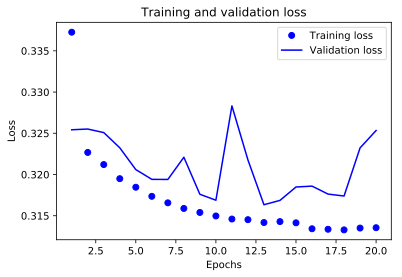

In [24]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

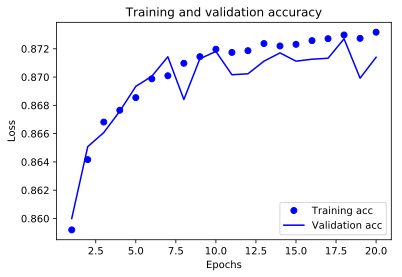

In [25]:
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
history.params

{'batch_size': 32,
 'do_validation': True,
 'epochs': 20,
 'metrics': ['loss', 'acc', 'val_loss', 'val_acc'],
 'samples': 87362,
 'steps': None,
 'verbose': 1}